<a href="https://colab.research.google.com/github/konderal333/HGT-2022-EmDomArDon/blob/main/tokenizer_512.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!git clone https://github.com/konderal333/HGT-2022-EmDomArDon.git

fatal: destination path 'HGT-2022-EmDomArDon' already exists and is not an empty directory.


In [6]:
import numpy as np
import pandas as pd

In [7]:
df = pd.read_csv("/content/HGT-2022-EmDomArDon/cikkek_10k_cleanedv1.csv")

In [8]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
from transformers import AutoTokenizer, AutoModel

In [10]:
tokenizer = AutoTokenizer.from_pretrained("SZTAKI-HLT/hubert-base-cc")
model = AutoModel.from_pretrained("SZTAKI-HLT/hubert-base-cc")

Some weights of the model checkpoint at SZTAKI-HLT/hubert-base-cc were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
!pip install quntoken
from quntoken import tokenize   #module to break text into sentences

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import re
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

<p>Method to reduce the length of sentences with more than 510 tokens:
<p>We get the first few whole sentences until we reach 255 tokens. (Let us assume that we get n tokens from these sentences, where n&#60;255). Then we get the last few whole sentences until these reach the remaining limit of tokens (510-n).
<p>So with this method we reduce the longer articles to 510 tokens (or a bit less than 510), so that we get the beginning and the end of the article.

In [13]:
def text_to_token_list(art_title, x):      
  token_list = []

  x = re.sub(r"(\.)([A-Z])", r'\1 \2', x) # fixes missings whitespaces between sentences
 
  for sen in nltk.tokenize.sent_tokenize(x):
    token_list.append(tokenizer.tokenize(sen))

  return token_list

In [14]:
dict_of_tokens = {} 
#this dict will contain the article title as keys and the tokenized lists from the function below as values

def text_to_tokens(art_title, x):      
  #insert the text to tokenize; first breaks text into sentences, then makes a list of lists with the i-th element being the tokenization of the i-th sentence
  #dictionary is being used for faster computation and easier accessibility
  sentence_list = []
  token_list = []

  x = re.sub(r"(\.)([A-Z])", r'\1 \2', x) # fixes missings whitespaces between sentences

  a = text_to_token_list(art_title, x)
  len1 = 0
  for i in a:
    for j in i:
      len1 +=1

  #if the text is > 510 tokens, we will get the first few whole sentences (~255 tokens), and the last few whole sentences (~255 tokens)
  if len1 > 510:
    eleje_sum = 0
    eleje_tokens = []
    for elem1 in a:
      if eleje_sum + len(elem1) > 255:
        break
      else:
        eleje_sum += len(elem1)
        eleje_tokens.append(elem1)

    vege_sum = 0
    vege_tokens = []
    a.reverse()
    for elem2 in a:
      if vege_sum + len(elem2) > 510-eleje_sum:
        break
      else:
        vege_sum += len(elem2)
        vege_tokens.append(elem2)

    vege_tokens.reverse()

    final_tokens = []
    for elem3 in eleje_tokens:
      final_tokens.append(elem3)
    for elem4 in vege_tokens:
      final_tokens.append(elem4)

    dict_of_tokens[art_title] = final_tokens

  #if the text is < 510 tokens, we do not have to get the beginning and the end, we can use the whole text
  else:
    for sen in nltk.tokenize.sent_tokenize(x):
      sentence_list.append(sen)
      token_list.append(tokenizer.tokenize(sen))

    dict_of_tokens[art_title] = token_list

In [15]:
# making the BERT tokenized sentences from each article

for i in range(len(df.Title)):
  text_to_tokens(df.Title[i].strip(), df.Textbody[i])

In [16]:
import matplotlib.pyplot as plt
import statistics

number_of_tokens_all = []

for tokens in dict_of_tokens.values():
  length = 0
  for lists in tokens:
    length += len(lists)
  number_of_tokens_all.append(length)

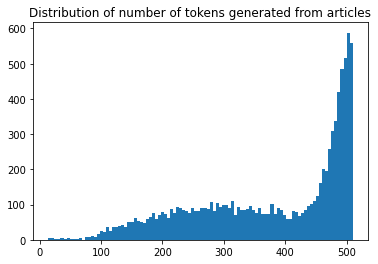

In [17]:
plt.hist(number_of_tokens_all, bins=100, density=False)
plt.title('Distribution of number of tokens generated from articles')
plt.show()

In [18]:
# number of articles with tokens more that 510:
print(np.sum(np.asarray(number_of_tokens_all) > 510))

0




---



This is another method, which we won't use, but I'll leave the code here.

510 token (or a bit less according to where the last sentence ends) from the **BEGINNING** of the articles

In [19]:
dict_of_tokens2 = {} 
#this dict will contain the article title as keys and the tokenized lists from the function below as values

def text_to_tokens2(art_title, x):      
  #insert the text to tokenize; first breaks text into sentences, then makes a list of lists with the i-th element being the tokenization of the i-th sentence
  #dictionary is being used for faster computation and easier accessibility
  sentence_list = []
  token_list = []

  x = re.sub(r"(\.)([A-Z])", r'\1 \2', x) # fixes missings whitespaces between sentences
 
  for sen in nltk.tokenize.sent_tokenize(x):
    # a is the same as token_list, but we need a different variable than token_list to check
    # whether the length will be longer than 510 tokens if we add another sentence or not
    a = []

    for elem in token_list:
      a.append(elem)
    a.append(tokenizer.tokenize(sen))

    # b is the number of tokens in a
    b = 0
    for i in a:
      for j in i:
        b += 1

    #now we check whether adding another sentence will result in more than 510 tokens
    if b > 510:
      break
    else:
      sentence_list.append(sen)
      token_list.append(tokenizer.tokenize(sen))

  dict_of_tokens2[art_title] = token_list

In [20]:
# making the BERT tokenized sentences from each article

for i in range(len(df.Title)):
  text_to_tokens2(df.Title[i].strip(), df.Textbody[i])

In [21]:
import matplotlib.pyplot as plt
import statistics

number_of_tokens_all2 = []

for tokens in dict_of_tokens2.values():
  length = 0
  for lists in tokens:
    length += len(lists)
  number_of_tokens_all2.append(length)

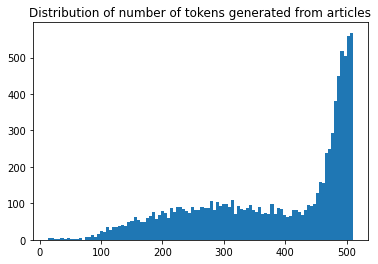

In [22]:
plt.hist(number_of_tokens_all2, bins=100, density=False)
plt.title('Distribution of number of tokens generated from articles')
plt.show()

In [23]:
# number of articles with tokens more that 510:
print(np.sum(np.asarray(number_of_tokens_all2) > 510))

0
